In [1]:
from mne.beamformer import make_lcmv, apply_lcmv, apply_lcmv_raw
import mne
import numpy as np
from hdf5storage import loadmat, savemat 
from matplotlib import pyplot as plt

In [2]:
raw_fname = './raw.fif'
raw=mne.io.read_raw_fif(raw_fname)
fwd = mne.read_forward_solution('fwd.fif')

Opening raw data file ./raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 32)  idle
    Range : 0 ... 258121 =      0.000 ...   129.060 secs
Ready.
Reading forward solution from /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan/fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (5124 sources, 32 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


/tmp/ipykernel_540096/3020075004.py:3: RuntimeWarning: This filename (fwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution('fwd.fif')


In [3]:
# data_cov=mne.compute_raw_covariance(raw)

In [4]:
# noise_cov = mne.read_cov('noise_cov.fif')
data_cov=mne.read_cov('sim_cov.fif')

    32 x 32 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 32)  idle


In [5]:
filters = make_lcmv(
    raw.info,
    fwd,
    data_cov,
    reg=0.05,
    noise_cov=None,
    pick_ori="max-power",
    weight_norm="unit-noise-gain",
    rank=None,
)

# You can save the filter for later use with:
# filters.save('filters-lcmv.h5')

# stc = apply_lcmv(evoked, filters)
stc = apply_lcmv_raw(raw,filters) 
#

Computing rank from covariance with rank=None
    Using tolerance 2.2e-11 (2.2e-16 eps * 32 dim * 3e+03  max singular value)
    Estimated rank (eeg): 31
    EEG: rank 31 computed from 32 data channels with 1 projector
Computing rank from covariance with rank=None
    EEG: rank 31 computed from 32 data channels with 1 projector
Making LCMV beamformer with rank {'eeg': 31}
Computing inverse operator with 32 channels.
    32 out of 32 channels remain after picking
Selected 32 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank={'eeg': 31}
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 5124 sources


Filter computation complete


In [6]:
stc_data=stc.data

In [7]:
outdict=loadmat('20220713_method_MNE_ico_4_scale_0.01_depth_0.8.mat')
outdict.keys()

dict_keys(['Coordinates', 'ch_bad', 'ch_dubious', 'ch_names', 'conductivity', 'corrcoef_diag', 'depth', 'invmat', 'leadfield', 'scale', 'sim_cov_mat', 'source_rr', 'subject_ID'])

In [8]:
leadfield=outdict['leadfield']
invmat=outdict['invmat']

In [9]:
outdict=loadmat('preprocessed_eeg.mat')
outdict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ch_bad', 'ch_dubious', 'ch_labels', 'chanlocs', 'preprocessed_eeg', 'subject_ID'])

In [10]:
preprocessed_eeg=outdict['preprocessed_eeg']

In [11]:
outdict=loadmat('Lausanne2008_fsaverageDSsurf_60_125_250.mat')

In [12]:
outdict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Brain', 'roiNames_125', 'roiNames_250', 'roiNames_60', 'scale125_Labels', 'scale125_subcortROIs', 'scale250_Labels', 'scale250_subcortROIs', 'scale60_Labels', 'scale60_subcortROIs'])

In [13]:
Brain = outdict['Brain'][0][0]
Vertex = outdict['Brain'][0][0][0]
Face = outdict['Brain'][0][0][1]
roiNames_60 =outdict['roiNames_60'][0]
roiNames_125=outdict['roiNames_125'][0]
roiNames_250=outdict['roiNames_250'][0]
scale60_Labels=outdict['scale60_Labels'][0]
scale125_Labels=outdict['scale125_Labels'][0]
scale250_Labels=outdict['scale250_Labels'][0]
scale60_subcortROIs=outdict['scale60_subcortROIs'][0]
scale125_subcortROIs=outdict['scale125_subcortROIs'][0]
scale250_subcortROIs=outdict['scale250_subcortROIs'][0]

In [14]:
recon_eeg=np.matmul(leadfield,stc_data)
# compute correlation
corr = np.corrcoef(recon_eeg, preprocessed_eeg, rowvar=True)
corrcoef_diag_lcmv=np.zeros((np.shape(recon_eeg)[0]))
for i in range(np.shape(recon_eeg)[0]):
    corrcoef_diag_lcmv[i]=corr[i,np.shape(recon_eeg)[0]+i]

/tmp/ipykernel_540096/3702677249.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  corrcoef_diag_lcmv[i]=corr[i,np.shape(recon_eeg)[0]+i]


In [15]:
source_data=np.matmul(invmat,preprocessed_eeg)
EEG_recon=np.matmul(leadfield,source_data)
# compute correlation
corr = np.corrcoef(EEG_recon, preprocessed_eeg, rowvar=True)
corrcoef_diag=np.zeros((np.shape(EEG_recon)[0]))
for i in range(np.shape(EEG_recon)[0]):
    corrcoef_diag[i]=corr[i,np.shape(EEG_recon)[0]+i]

Text(0.5, 1.0, 'red: source-data = inverse mat x original eeg\nblue: source-data = leadfield mat x source data from mne.beamformer.make_lcmv')

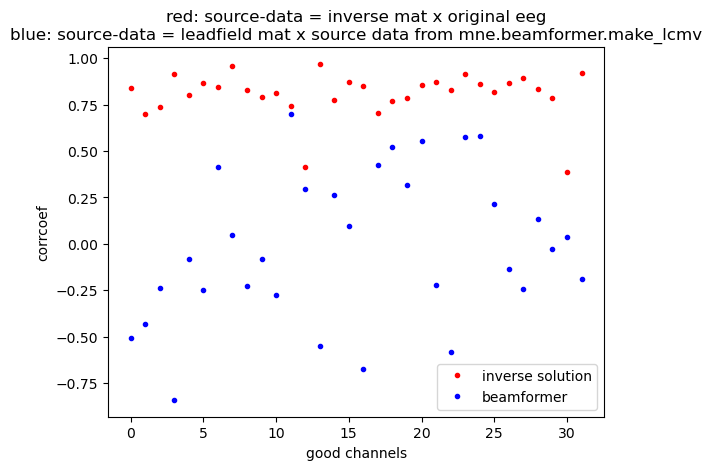

: 

In [18]:
plt.plot(np.arange(0, np.shape(EEG_recon)[0],1) ,corrcoef_diag, 'r.',label='inverse solution')
plt.plot(np.arange(0, np.shape(EEG_recon)[0],1) ,corrcoef_diag_lcmv, 'b.',label='beamformer')
plt.legend()
plt.xlabel('good channels')
plt.ylabel('corrcoef')
plt.title('red: source-data = inverse mat x original eeg\nblue: source-data = leadfield mat x source data from mne.beamformer.make_lcmv')